In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


In [2]:
df = pd.read_parquet('./Data/draft0522.parquet')

In [3]:
model_df = df.drop(['school_name'],axis=1)

In [4]:
model_df.Round[model_df.Round <= 3] = 2

C:\Users\capta\AppData\Local\Temp\ipykernel_15096\2943970229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.Round[model_df.Round <= 3] = 2


In [5]:
model_df.Round[model_df.Round == 8] = 0

C:\Users\capta\AppData\Local\Temp\ipykernel_15096\3023946570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.Round[model_df.Round == 8] = 0


In [6]:
model_df.Round[model_df.Round >=4] = 1

C:\Users\capta\AppData\Local\Temp\ipykernel_15096\4119251177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.Round[model_df.Round >=4] = 1


In [7]:
model_df.Round.value_counts(normalize=True)

0.0    0.358002
1.0    0.349761
2.0    0.292237
Name: Round, dtype: float64

In [8]:
X = model_df.drop(['Round'],axis=1)
y = model_df.Round

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team

X_train.drop(['player','pick','year','team'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

pipe = Pipeline(steps=[
    ('trans',transformer),
    ('gaus',GaussianMixture(random_state=42))])

grid = {'gaus__n_components':[4,5,6,7,8,9,10]}

gridsearch = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler()),
                                                                                         ('impute',
                                                                                          SimpleImputer(strategy='constant'))]),
                                                                         Index(['height', 'weight', 'forty_yd', 'vertical', 'bench_reps', 'broad_jump',
       'cone', 'shuttle', 'g_season', 'def_int_season', 'def_int_yds_season',
       'def_int_yds_per_int_season', 'd...
       'fumbles_forced_season', 'fumbles_forced_career', 'Age', 'speed',
       'agility', 'alt_agility'],
      dtype='object')),
              

In [11]:
gridsearch.best_params_

{'gaus__n_components': 4}

In [12]:
gridsearch.n_splits_

5

In [13]:
gridsearch.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler()),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  Index(['height', 'weight', 'forty_yd', 'vertical', 'bench_reps', 'broad_jump',
       'cone', 'shuttle', 'g_season', 'def_int_season', 'def_int_yds_season',
       'def_int_yds_per_int_season', 'def_int_career', 'def_int_yds_...
       'tackles_loss_career', 'sacks_career', 'pass_defended_career',
       'fumbles_forced_season', 'fumbles_forced_career', 'Age', 'speed',
       'agility', 'alt_agility'],
      dtype='object')),
                                                 ('cat',
                                      

In [14]:
from copy import deepcopy
preprocess = deepcopy(gridsearch.best_estimator_)

preprocess.steps.pop()

('gaus', GaussianMixture(n_components=4, random_state=42))

In [15]:
X_transformed = preprocess.transform(X_train)

In [16]:
gridsearch.best_estimator_[-1].bic(X_transformed)

-2745130.781855205

In [17]:
y_pred = gridsearch.predict_proba(X_test)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
h = pd.DataFrame(y_pred)

In [26]:
h

,0,1,2,3
0,1.0,0.0,3.770336e-55,0.000000e+00
1,0.0,0.0,0.000000e+00,1.000000e+00
2,0.0,1.0,0.000000e+00,0.000000e+00
3,0.0,1.0,0.000000e+00,0.000000e+00
4,1.0,0.0,3.817528e-48,3.480438e-69
...,...,...,...,...
1998,0.0,0.0,0.000000e+00,1.000000e+00
1999,0.0,0.0,0.000000e+00,1.000000e+00
2000,0.0,1.0,0.000000e+00,0.000000e+00
2001,0.0,1.0,0.000000e+00,0.000000e+00


In [19]:
from sklearn.manifold import TSNE

In [22]:
tsne = TSNE(random_state=42,learning_rate=100)
tsne_trans = tsne.fit_transform(h)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1','TSNE2'])

C:\Users\capta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [34]:
tsne_trans['class'] = np.argmax(h.values, axis = 1)

In [35]:
tsne_trans

,TSNE1,TSNE2,class
0,5.488305,-13.571383,0
1,-2.883079,25.529081,3
2,-21.648020,-4.094162,1
3,-21.723021,-4.070070,1
4,3.488823,-15.918584,0
...,...,...,...
1998,-3.871777,23.826612,3
1999,-3.871777,23.826612,3
2000,-21.726894,-5.238549,1
2001,-21.726894,-5.238549,1


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

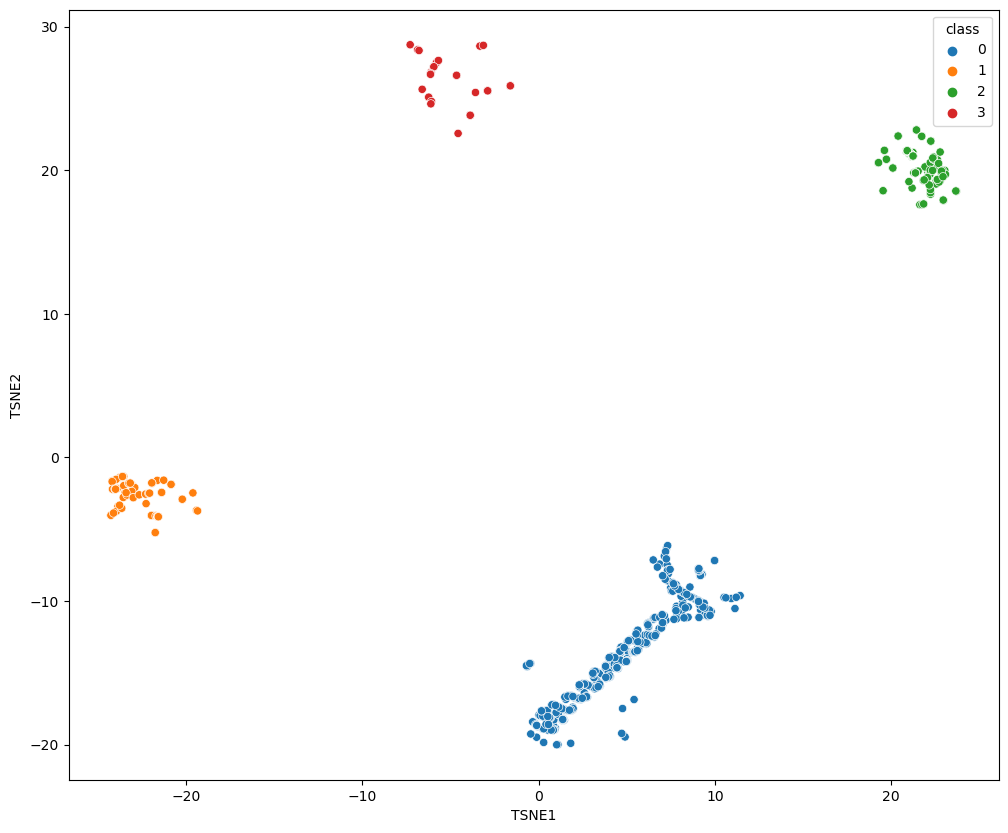

In [38]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=tsne_trans.TSNE1,y=tsne_trans.TSNE2, hue=tsne_trans['class'], palette = 'tab10')

In [39]:
X_test

,pos,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,...,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,college_conference,Age,speed,agility,alt_agility
2763,DT,75.0,313.0,5.06,26.5,30.0,101.0,NaN,NaN,NaN,...,13.5,5.0,3.0,NaN,2.0,None,NaN,95.493160,NaN,NaN
3758,RB,72.0,238.0,4.64,NaN,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,102.691626,NaN,NaN
1652,WR,74.0,188.0,4.52,40.0,NaN,122.0,7.03,4.43,13.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,90.081188,97.627673,108.223573
3872,WR,73.0,199.0,4.54,32.5,17.0,116.0,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,93.682756,NaN,NaN
5143,LB,75.0,241.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,...,24.5,14.5,1.0,2.0,6.0,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,S,71.0,203.0,4.45,36.5,20.0,121.0,7.28,4.30,12.0,...,12.0,1.5,NaN,NaN,NaN,None,NaN,103.534714,118.755084,105.228140
4714,S,72.0,209.0,4.63,34.5,17.0,114.0,7.45,4.30,13.0,...,14.0,1.0,13.0,NaN,NaN,None,NaN,90.960391,122.265087,101.089829
2622,WR,74.0,206.0,4.58,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,Pacific Twelve Conference,21.0,93.634372,NaN,NaN
5693,TE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


In [ ]:
look = 